    *************************** CASE STUDY HEALTHCARE DATA ANALYSIS (PART 3) ***********************************

    PART 3: Identify 10,000 Medicare patients who were involved in anomalous activities

    #1. Importing Libraries and datasets

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as stats
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import pandas_profiling
%matplotlib inline

C:\Users\lenovo\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\lenovo\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas_profiling\base.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda2\lib\runpy.py", line 174, in _run_module_as_main
    "__main__

In [5]:
Patient_history = pd.read_csv('Patient_history_samp.csv')
Review_patient = pd.read_csv('Review_patient_history_samp.csv')
Review_transaction = pd.read_csv('Rreview_transaction_coo.csv')
Transaction = pd.read_csv('Transaction_coo.csv')

    #2. Data Analysis and Data Preparation

    Generally for anomaly detection, we aim to learn what is most representative of ‘normal’, 
    then anything outside of some threshold can be considered an anomaly
    
    Review_patient_history_samp.csv and Rreview_transaction_coo.csv datasets are the details for reviewed patient.
    Patient_history_samp.csv and Transaction_coo.csv are unclassified patient.
    
    We have to identify the cause/pattern for the review patient and based on that the unmarked patients needs to be marked.

In [6]:
Patient_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
id        500000 non-null int64
age       497470 non-null object
gender    500000 non-null object
income    497469 non-null object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB


In [7]:
Review_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
id        5000 non-null int64
age       4974 non-null object
gender    5000 non-null object
income    4974 non-null object
dtypes: int64(1), object(3)
memory usage: 156.3+ KB


In [8]:
Patient_history.groupby('gender')['id'].nunique()

gender
F    274512
M    225488
Name: id, dtype: int64

In [9]:
Patient_history.groupby('income')['id'].nunique()

income
16000-23999    102492
24000-31999     75670
32000-47999     95899
48000+         115865
<16000         107543
Name: id, dtype: int64

In [10]:
Patient_history.groupby('age')['id'].nunique()

age
65-74    219329
75-84    128992
85+       64581
<65       84568
Name: id, dtype: int64

    Transforming categorical variables to numerical variables (grouping) for better data preprocesing
    and dropping the categorical variables

In [11]:
#function to get the income group indicator
def incometyp(patient):
    if (patient['income']  == '16000-23999'):
        return 2
    elif (patient['income']  == '24000-31999'):
        return 3
    elif (patient['income']  == '32000-47999'):
        return 4
    elif (patient['income']  == '48000+'):
        return 5
    else:
        return 1

In [12]:
#function to get the age group indicator
def agetyp(patient):
    if (patient['age']  == '65-74'):
        return 2
    elif (patient['age']  == '75-84'):
        return 3
    elif (patient['age']  == '85+'):
        return 4
    else:
        return 1

In [13]:
#function to get the gender group indicator
def gendertyp(patient):
    if (patient['gender']  == 'M'):
        return 1
    else:
        return 0

    Executing the functions on review and unmarked datasets

In [14]:
Patient_history['INCOME_GROUP'] = Patient_history.apply(incometyp, axis=1)

In [15]:
Patient_history['AGE_GROUP'] = Patient_history.apply(agetyp, axis=1)

In [16]:
Patient_history['GENDER_GROUP'] = Patient_history.apply(gendertyp, axis=1)

In [17]:
Review_patient['INCOME_GROUP'] = Review_patient.apply(incometyp, axis=1)

In [18]:
Review_patient['AGE_GROUP'] = Review_patient.apply(agetyp, axis=1)

In [19]:
Review_patient['GENDER_GROUP'] = Review_patient.apply(gendertyp, axis=1)

In [20]:
Patient_history.drop(['age', 'gender', 'income'], axis =1 , inplace = True)

In [21]:
Review_patient.drop(['age', 'gender', 'income'], axis =1 , inplace = True)

    Create dummies to count and sum the number of procedure used by patient
    Grouping them at patient level - so that there are 1 row per patient for the transaction dataset

    For full dataset - unlabeled

In [22]:
col_dummies=pd.get_dummies(Transaction['global_proc_id'], prefix='proc')
Transaction_cat = pd.concat([Transaction, col_dummies], axis=1)
Transaction_cat.drop( 'global_proc_id', axis = 1, inplace = True )

In [23]:
Transaction_grouped = pd.DataFrame(Transaction_cat[['id', 'count','proc_1' ,'proc_2' ,'proc_3' ,'proc_4' ,'proc_5' ,
                                                    'proc_6' ,'proc_7' ,'proc_8' ,'proc_9' ,'proc_10' ,'proc_11' ,
                                                    'proc_12' ,'proc_13' ,'proc_14' ,'proc_15' ,'proc_16' ,'proc_17' ,
                                                    'proc_18' ,'proc_19' ,'proc_20' ,'proc_21' ,'proc_22' ,'proc_23' ,
                                                    'proc_24' ,'proc_25' ,'proc_26' ,'proc_27' ,'proc_28' ,'proc_29' ,
                                                    'proc_30' ,'proc_31' ,'proc_32' ,'proc_33' ,'proc_34' ,'proc_35' ,
                                                    'proc_36' ,'proc_37' ,'proc_38' ,'proc_39' ,'proc_40' ,'proc_41' ,
                                                    'proc_42' ,'proc_43' ,'proc_44' ,'proc_45' ,'proc_46' ,'proc_47' ,
                                                    'proc_48' ,'proc_49' ,'proc_50' ,'proc_51' ,'proc_52' ,'proc_53' ,
                                                    'proc_54' ,'proc_55' ,'proc_56' ,'proc_57' ,'proc_58' ,'proc_59' ,
                                                    'proc_60' ,'proc_61' ,'proc_62' ,'proc_63' ,'proc_64' ,'proc_65' ,
                                                    'proc_66' ,'proc_67' ,'proc_68' ,'proc_69' ,'proc_70' ,'proc_71' ,
                                                    'proc_72' ,'proc_73' ,'proc_74' ,'proc_75' ,'proc_76' ,'proc_77' ,
                                                    'proc_78' ,'proc_79' ,'proc_80' ,'proc_81' ,'proc_82' ,'proc_83' ,
                                                    'proc_84' ,'proc_85' ,'proc_86' ,'proc_87' ,'proc_88' ,'proc_89' ,
                                                    'proc_90' ,'proc_91' ,'proc_92' ,'proc_93' ,'proc_94' ,'proc_95' ,
                                                    'proc_96' ,'proc_97' ,'proc_98' ,'proc_99' ,'proc_100' ,'proc_101' ,
                                                    'proc_102' ,'proc_103' ,'proc_104' ,'proc_105' ,'proc_106' ,
                                                    'proc_107' ,'proc_108' ,'proc_109' ,'proc_110' ,'proc_111' ,
                                                    'proc_112' ,'proc_113' ,'proc_114' ,'proc_115' ,'proc_116' ,
                                                    'proc_117' ,'proc_118' ,'proc_119' ,'proc_120' ,'proc_121' ,
                                                    'proc_122' ,'proc_123' ,'proc_124' ,'proc_125' ,'proc_126' ,
                                                    'proc_127' ,'proc_128' ,'proc_129' ,'proc_130']].groupby(['id']).agg({'count':'sum',
                                                                                         'proc_1' :'sum' ,
                                                                                         'proc_2' :'sum' ,
                                                                                         'proc_3' :'sum' ,
                                                                                         'proc_4' :'sum' ,
                                                                                         'proc_5' :'sum' ,
                                                                                         'proc_6' :'sum' ,
                                                                                         'proc_7' :'sum' ,
                                                                                         'proc_8' :'sum' ,
                                                                                         'proc_9' :'sum' ,
                                                                                         'proc_10' :'sum' ,
                                                                                         'proc_11' :'sum' ,
                                                                                         'proc_12' :'sum' ,
                                                                                         'proc_13' :'sum' ,
                                                                                         'proc_14' :'sum' ,
                                                                                         'proc_15' :'sum' ,
                                                                                         'proc_16' :'sum' ,
                                                                                         'proc_17' :'sum' ,
                                                                                         'proc_18' :'sum' ,
                                                                                         'proc_19' :'sum' ,
                                                                                         'proc_20' :'sum' ,
                                                                                         'proc_21' :'sum' ,
                                                                                         'proc_22' :'sum' ,
                                                                                         'proc_23' :'sum' ,
                                                                                         'proc_24' :'sum' ,
                                                                                         'proc_25' :'sum' ,
                                                                                         'proc_26' :'sum' ,
                                                                                         'proc_27' :'sum' ,
                                                                                         'proc_28' :'sum' ,
                                                                                         'proc_29' :'sum' ,
                                                                                         'proc_30' :'sum' ,
                                                                                         'proc_31' :'sum' ,
                                                                                         'proc_32' :'sum' ,
                                                                                         'proc_33' :'sum' ,
                                                                                         'proc_34' :'sum' ,
                                                                                         'proc_35' :'sum' ,
                                                                                         'proc_36' :'sum' ,
                                                                                         'proc_37' :'sum' ,
                                                                                         'proc_38' :'sum' ,
                                                                                         'proc_39' :'sum' ,
                                                                                         'proc_40' :'sum' ,
                                                                                         'proc_41' :'sum' ,
                                                                                         'proc_42' :'sum' ,
                                                                                         'proc_43' :'sum' ,
                                                                                         'proc_44' :'sum' ,
                                                                                         'proc_45' :'sum' ,
                                                                                         'proc_46' :'sum' ,
                                                                                         'proc_47' :'sum' ,
                                                                                         'proc_48' :'sum' ,
                                                                                         'proc_49' :'sum' ,
                                                                                         'proc_50' :'sum' ,
                                                                                         'proc_51' :'sum' ,
                                                                                         'proc_52' :'sum' ,
                                                                                         'proc_53' :'sum' ,
                                                                                         'proc_54' :'sum' ,
                                                                                         'proc_55' :'sum' ,
                                                                                         'proc_56' :'sum' ,
                                                                                         'proc_57' :'sum' ,
                                                                                         'proc_58' :'sum' ,
                                                                                         'proc_59' :'sum' ,
                                                                                         'proc_60' :'sum' ,
                                                                                         'proc_61' :'sum' ,
                                                                                         'proc_62' :'sum' ,
                                                                                         'proc_63' :'sum' ,
                                                                                         'proc_64' :'sum' ,
                                                                                         'proc_65' :'sum' ,
                                                                                         'proc_66' :'sum' ,
                                                                                         'proc_67' :'sum' ,
                                                                                         'proc_68' :'sum' ,
                                                                                         'proc_69' :'sum' ,
                                                                                         'proc_70' :'sum' ,
                                                                                         'proc_71' :'sum' ,
                                                                                         'proc_72' :'sum' ,
                                                                                         'proc_73' :'sum' ,
                                                                                         'proc_74' :'sum' ,
                                                                                         'proc_75' :'sum' ,
                                                                                         'proc_76' :'sum' ,
                                                                                         'proc_77' :'sum' ,
                                                                                         'proc_78' :'sum' ,
                                                                                         'proc_79' :'sum' ,
                                                                                         'proc_80' :'sum' ,
                                                                                         'proc_81' :'sum' ,
                                                                                         'proc_82' :'sum' ,
                                                                                         'proc_83' :'sum' ,
                                                                                         'proc_84' :'sum' ,
                                                                                         'proc_85' :'sum' ,
                                                                                         'proc_86' :'sum' ,
                                                                                         'proc_87' :'sum' ,
                                                                                         'proc_88' :'sum' ,
                                                                                         'proc_89' :'sum' ,
                                                                                         'proc_90' :'sum' ,
                                                                                         'proc_91' :'sum' ,
                                                                                         'proc_92' :'sum' ,
                                                                                         'proc_93' :'sum' ,
                                                                                         'proc_94' :'sum' ,
                                                                                         'proc_95' :'sum' ,
                                                                                         'proc_96' :'sum' ,
                                                                                         'proc_97' :'sum' ,
                                                                                         'proc_98' :'sum' ,
                                                                                         'proc_99' :'sum' ,
                                                                                         'proc_100' :'sum' ,
                                                                                         'proc_101' :'sum' ,
                                                                                         'proc_102' :'sum' ,
                                                                                         'proc_103' :'sum' ,
                                                                                         'proc_104' :'sum' ,
                                                                                         'proc_105' :'sum' ,
                                                                                         'proc_106' :'sum' ,
                                                                                         'proc_107' :'sum' ,
                                                                                         'proc_108' :'sum' ,
                                                                                         'proc_109' :'sum' ,
                                                                                         'proc_110' :'sum' ,
                                                                                         'proc_111' :'sum' ,
                                                                                         'proc_112' :'sum' ,
                                                                                         'proc_113' :'sum' ,
                                                                                         'proc_114' :'sum' ,
                                                                                         'proc_115' :'sum' ,
                                                                                         'proc_116' :'sum' ,
                                                                                         'proc_117' :'sum' ,
                                                                                         'proc_118' :'sum' ,
                                                                                         'proc_119' :'sum' ,
                                                                                         'proc_120' :'sum' ,
                                                                                         'proc_121' :'sum' ,
                                                                                         'proc_122' :'sum' ,
                                                                                         'proc_123' :'sum' ,
                                                                                         'proc_124' :'sum' ,
                                                                                         'proc_125' :'sum' ,
                                                                                         'proc_126' :'sum' ,
                                                                                         'proc_127' :'sum' ,
                                                                                         'proc_128' :'sum' ,
                                                                                         'proc_129' :'sum' ,
                                                                                         'proc_130' :'sum' }))

In [24]:
Transaction_grouped.head()

,proc_57,proc_56,proc_19,proc_18,proc_53,proc_52,proc_51,proc_50,proc_13,proc_12,...,proc_35,proc_34,proc_37,proc_36,proc_31,proc_30,proc_33,proc_32,proc_39,proc_38
id,,,,,,,,,,,,,,,,,,,,,
623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7619,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
10479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
Transaction_grouped = Transaction_grouped.reset_index()

In [26]:
full_dataset = Transaction_grouped.merge(Patient_history,on='id', how='left')

    For review dataset - labeled

In [27]:
col_dummies=pd.get_dummies(Review_transaction['global_proc_id'], prefix='proc')
Review_transaction_cat = pd.concat([Review_transaction, col_dummies], axis=1)
Review_transaction_cat.drop( 'global_proc_id', axis = 1, inplace = True )

In [28]:
Review_transaction_grouped = pd.DataFrame(Review_transaction_cat[['id', 'count','proc_1' ,'proc_2' ,'proc_3' ,'proc_5' ,
                                                    'proc_6' ,'proc_7' ,'proc_8' ,'proc_9' ,'proc_10' ,'proc_11' ,
                                                    'proc_12' ,'proc_13' ,'proc_14' ,'proc_15' ,'proc_16' ,'proc_17' ,
                                                    'proc_18' ,'proc_19' ,'proc_20' ,'proc_21' ,'proc_22' ,'proc_23' ,
                                                    'proc_24' ,'proc_25' ,'proc_26' ,'proc_27' ,'proc_28' ,'proc_29' ,
                                                    'proc_30' ,'proc_31' ,'proc_32' ,'proc_33' ,'proc_34' ,'proc_35' ,
                                                    'proc_36' ,'proc_37' ,'proc_38' ,'proc_39' ,'proc_40' ,'proc_41' ,
                                                    'proc_42' ,'proc_43' ,'proc_44' ,'proc_45' ,'proc_46' ,'proc_47' ,
                                                    'proc_48' ,'proc_49' ,'proc_50' ,'proc_51' ,'proc_52' ,'proc_53' ,
                                                    'proc_54' ,'proc_55' ,'proc_56' ,'proc_57' ,'proc_58' ,'proc_59' ,
                                                    'proc_60' ,'proc_61' ,'proc_62' ,'proc_63' ,'proc_64' ,'proc_65' ,
                                                    'proc_66' ,'proc_67' ,'proc_68' ,'proc_69' ,'proc_70' ,'proc_71' ,
                                                    'proc_72' ,'proc_73' ,'proc_74' ,'proc_75' ,'proc_76' ,'proc_77' ,
                                                    'proc_78' ,'proc_79' ,'proc_80' ,'proc_81' ,'proc_82' ,'proc_83' ,
                                                    'proc_84' ,'proc_85' ,'proc_86' ,'proc_87' ,'proc_88' ,'proc_89' ,
                                                    'proc_90' ,'proc_91' ,'proc_92' ,'proc_93' ,'proc_94' ,'proc_95' ,
                                                    'proc_96' ,'proc_97' ,'proc_98' ,'proc_99' ,'proc_100' ,'proc_101' ,
                                                    'proc_102' ,'proc_103' ,'proc_104' ,'proc_105' ,'proc_106' ,
                                                    'proc_107' ,'proc_108' ,'proc_109' ,'proc_110' ,'proc_111' ,
                                                    'proc_112' ,'proc_113' ,'proc_114' ,'proc_115' ,'proc_116' ,
                                                    'proc_117' ,'proc_118' ,'proc_119' ,'proc_120' ,'proc_121' ,
                                                    'proc_122' ,'proc_123' ,'proc_124' ,'proc_125' ,'proc_126' ,
                                                    'proc_127' ,'proc_128' ,'proc_129' ,'proc_130']].groupby(['id']).agg({'count':'sum',
                                                                                         'proc_1' :'sum' ,
                                                                                         'proc_2' :'sum' ,
                                                                                         'proc_3' :'sum' ,
                                                                                         'proc_5' :'sum' ,
                                                                                         'proc_6' :'sum' ,
                                                                                         'proc_7' :'sum' ,
                                                                                         'proc_8' :'sum' ,
                                                                                         'proc_9' :'sum' ,
                                                                                         'proc_10' :'sum' ,
                                                                                         'proc_11' :'sum' ,
                                                                                         'proc_12' :'sum' ,
                                                                                         'proc_13' :'sum' ,
                                                                                         'proc_14' :'sum' ,
                                                                                         'proc_15' :'sum' ,
                                                                                         'proc_16' :'sum' ,
                                                                                         'proc_17' :'sum' ,
                                                                                         'proc_18' :'sum' ,
                                                                                         'proc_19' :'sum' ,
                                                                                         'proc_20' :'sum' ,
                                                                                         'proc_21' :'sum' ,
                                                                                         'proc_22' :'sum' ,
                                                                                         'proc_23' :'sum' ,
                                                                                         'proc_24' :'sum' ,
                                                                                         'proc_25' :'sum' ,
                                                                                         'proc_26' :'sum' ,
                                                                                         'proc_27' :'sum' ,
                                                                                         'proc_28' :'sum' ,
                                                                                         'proc_29' :'sum' ,
                                                                                         'proc_30' :'sum' ,
                                                                                         'proc_31' :'sum' ,
                                                                                         'proc_32' :'sum' ,
                                                                                         'proc_33' :'sum' ,
                                                                                         'proc_34' :'sum' ,
                                                                                         'proc_35' :'sum' ,
                                                                                         'proc_36' :'sum' ,
                                                                                         'proc_37' :'sum' ,
                                                                                         'proc_38' :'sum' ,
                                                                                         'proc_39' :'sum' ,
                                                                                         'proc_40' :'sum' ,
                                                                                         'proc_41' :'sum' ,
                                                                                         'proc_42' :'sum' ,
                                                                                         'proc_43' :'sum' ,
                                                                                         'proc_44' :'sum' ,
                                                                                         'proc_45' :'sum' ,
                                                                                         'proc_46' :'sum' ,
                                                                                         'proc_47' :'sum' ,
                                                                                         'proc_48' :'sum' ,
                                                                                         'proc_49' :'sum' ,
                                                                                         'proc_50' :'sum' ,
                                                                                         'proc_51' :'sum' ,
                                                                                         'proc_52' :'sum' ,
                                                                                         'proc_53' :'sum' ,
                                                                                         'proc_54' :'sum' ,
                                                                                         'proc_55' :'sum' ,
                                                                                         'proc_56' :'sum' ,
                                                                                         'proc_57' :'sum' ,
                                                                                         'proc_58' :'sum' ,
                                                                                         'proc_59' :'sum' ,
                                                                                         'proc_60' :'sum' ,
                                                                                         'proc_61' :'sum' ,
                                                                                         'proc_62' :'sum' ,
                                                                                         'proc_63' :'sum' ,
                                                                                         'proc_64' :'sum' ,
                                                                                         'proc_65' :'sum' ,
                                                                                         'proc_66' :'sum' ,
                                                                                         'proc_67' :'sum' ,
                                                                                         'proc_68' :'sum' ,
                                                                                         'proc_69' :'sum' ,
                                                                                         'proc_70' :'sum' ,
                                                                                         'proc_71' :'sum' ,
                                                                                         'proc_72' :'sum' ,
                                                                                         'proc_73' :'sum' ,
                                                                                         'proc_74' :'sum' ,
                                                                                         'proc_75' :'sum' ,
                                                                                         'proc_76' :'sum' ,
                                                                                         'proc_77' :'sum' ,
                                                                                         'proc_78' :'sum' ,
                                                                                         'proc_79' :'sum' ,
                                                                                         'proc_80' :'sum' ,
                                                                                         'proc_81' :'sum' ,
                                                                                         'proc_82' :'sum' ,
                                                                                         'proc_83' :'sum' ,
                                                                                         'proc_84' :'sum' ,
                                                                                         'proc_85' :'sum' ,
                                                                                         'proc_86' :'sum' ,
                                                                                         'proc_87' :'sum' ,
                                                                                         'proc_88' :'sum' ,
                                                                                         'proc_89' :'sum' ,
                                                                                         'proc_90' :'sum' ,
                                                                                         'proc_91' :'sum' ,
                                                                                         'proc_92' :'sum' ,
                                                                                         'proc_93' :'sum' ,
                                                                                         'proc_94' :'sum' ,
                                                                                         'proc_95' :'sum' ,
                                                                                         'proc_96' :'sum' ,
                                                                                         'proc_97' :'sum' ,
                                                                                         'proc_98' :'sum' ,
                                                                                         'proc_99' :'sum' ,
                                                                                         'proc_100' :'sum' ,
                                                                                         'proc_101' :'sum' ,
                                                                                         'proc_102' :'sum' ,
                                                                                         'proc_103' :'sum' ,
                                                                                         'proc_104' :'sum' ,
                                                                                         'proc_105' :'sum' ,
                                                                                         'proc_106' :'sum' ,
                                                                                         'proc_107' :'sum' ,
                                                                                         'proc_108' :'sum' ,
                                                                                         'proc_109' :'sum' ,
                                                                                         'proc_110' :'sum' ,
                                                                                         'proc_111' :'sum' ,
                                                                                         'proc_112' :'sum' ,
                                                                                         'proc_113' :'sum' ,
                                                                                         'proc_114' :'sum' ,
                                                                                         'proc_115' :'sum' ,
                                                                                         'proc_116' :'sum' ,
                                                                                         'proc_117' :'sum' ,
                                                                                         'proc_118' :'sum' ,
                                                                                         'proc_119' :'sum' ,
                                                                                         'proc_120' :'sum' ,
                                                                                         'proc_121' :'sum' ,
                                                                                         'proc_122' :'sum' ,
                                                                                         'proc_123' :'sum' ,
                                                                                         'proc_124' :'sum' ,
                                                                                         'proc_125' :'sum' ,
                                                                                         'proc_126' :'sum' ,
                                                                                         'proc_127' :'sum' ,
                                                                                         'proc_128' :'sum' ,
                                                                                         'proc_129' :'sum' ,
                                                                                         'proc_130' :'sum' }))

In [29]:
Review_transaction_grouped = Review_transaction_grouped.reset_index()

In [30]:
# Review dataset do not have patient opting for proc 4 - hence creating a dummy column with all zeros
Review_transaction_grouped['proc_4'] = 0

In [31]:
review_dataset = Review_transaction_grouped.merge(Review_patient,on='id', how='left')

    Adding flag to the review and unmarked datasets

In [32]:
full_dataset['REVIEW_IND'] = 0

In [33]:
review_dataset['REVIEW_IND'] = 1

    Aligning the data type - int64 to all dummy variables

In [34]:
list1 = (full_dataset.filter(like='proc').columns)

In [35]:
full_dataset[list1] = full_dataset[list1].astype('int64')
review_dataset[list1] = full_dataset[list1].astype('int64')

In [36]:
# Dropping columns having null values
full_dataset.dropna(axis=0, how='any', inplace = True)

In [37]:
full_dataset[['INCOME_GROUP', 'AGE_GROUP', 'GENDER_GROUP']] = full_dataset[['INCOME_GROUP', 'AGE_GROUP', 'GENDER_GROUP']].astype('int64')

In [38]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 1 to 505000
Columns: 136 entries, id to REVIEW_IND
dtypes: int64(136)
memory usage: 522.6 MB


In [39]:
review_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Columns: 136 entries, id to REVIEW_IND
dtypes: int64(136)
memory usage: 5.2 MB


In [40]:
full_dataset['id'].count()

500000

In [41]:
review_dataset['id'].count()

5000

    So at this moment we have 500000 unmarked patients and 5000 marked (review) patient.
    This is an imbalanced data.
    
    We have to create a model by sampling out data from unmarked dataset and overfitting the review patient to get
    a balanced data.

    #3. Using SMOTE (overfitting) and Random forest to perform association analysis

In [42]:
sample_dataset = full_dataset.sample(frac=0.1)

In [43]:
frames = [sample_dataset, review_dataset]
train_df = pd.concat(frames)

In [44]:
cols = train_df.columns.difference( ['REVIEW_IND', 'id'] )

In [45]:
df_train = train_df[cols ]
df_test = full_dataset[cols ]

In [46]:
from sklearn.cross_validation import train_test_split


train_X, test_X, train_y, test_y = train_test_split( train_df[cols ],
                                                  train_df['REVIEW_IND'],
                                                  test_size = 0.2,
                                                  random_state = 42 )

    Overfitting the data using SMOTE

In [47]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=123, ratio = 0.5)
x_train_res, y_train_res = sm.fit_sample(train_X,  train_y)

C:\Users\lenovo\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


    Using RANDOM Forest to get the final model and getting the prediction probabilities

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
df_test  = full_dataset.copy()

In [50]:
df_test[cols].head()

,AGE_GROUP,GENDER_GROUP,INCOME_GROUP,count,proc_1,proc_10,proc_100,proc_101,proc_102,proc_103,...,proc_90,proc_91,proc_92,proc_93,proc_94,proc_95,proc_96,proc_97,proc_98,proc_99
1,2,1,5,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,5,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,1,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,1,4,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


    Using the sampled overfitted data as train dataset and the complete unmarked data as test dataset

In [51]:
clf = RandomForestClassifier(n_estimators=50 )
clf.fit(x_train_res, y_train_res)

# Make predictions for train and test dataset
predictions_train = clf.predict(x_train_res)
probs_train = clf.predict_proba(x_train_res)
predictions = clf.predict(df_test[cols])
probs = clf.predict_proba(df_test[cols])
display(predictions)

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [52]:
score = clf.score(x_train_res, y_train_res)
print("Accuracy: ", score)

('Accuracy: ', 0.99458504806811177)


Text(0.5,15,u'Predicted label')

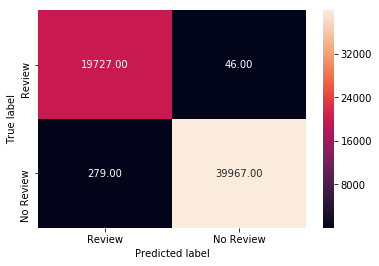

In [53]:
tree_cm = metrics.confusion_matrix( predictions_train,
                                 y_train_res, [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Review", "No Review"] , yticklabels = ["Review", "No Review"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

    This is more accurately identifying the REVIEW =1 indicator
    19705/20006 = 98%

In [54]:
#Predicting the test cases
predictions_train_df = pd.DataFrame( { 'actual':  y_train_res,
                            'predicted': predictions_train } )

In [55]:
probs_train_df = pd.DataFrame(probs_train)

In [56]:
train_pred = pd.concat( [predictions_train_df, probs_train_df], axis = 1 )

In [57]:
train_pred.columns = ['actual', 'predicted', 'Review_0', 'Review_1']

In [58]:
train_pred.head(10)

,actual,predicted,Review_0,Review_1
0,0,0,1.00,0.00
1,0,0,0.90,0.10
2,1,1,0.26,0.74
3,0,0,1.00,0.00
4,0,0,1.00,0.00
5,1,1,0.34,0.66
6,0,0,1.00,0.00
7,0,0,1.00,0.00
8,0,0,0.96,0.04
9,1,1,0.26,0.74


In [59]:
#Score for test Datasets
score = clf.score(df_test[cols], df_test["REVIEW_IND"])
print("Accuracy: ", score)

('Accuracy: ', 0.97242600000000001)


    There are 13787 patient who are showing as anomolous -REVIEW_ID predicted as 1 (having prediction prob > 0.5)
    This is close to our objective of finding 10000 patient

    Adding test probabilities with test datasets

In [65]:
df_test["prob_true"] = probs[:, 1]

In [66]:
df_anomalous= df_test[df_test["prob_true"] > 0.5 ]
df_anomalous["prob_true"].count()

13787

In [67]:
df_anomalous.head()

,id,proc_57,proc_56,proc_19,proc_18,proc_53,proc_52,proc_51,proc_50,proc_13,...,proc_30,proc_33,proc_32,proc_39,proc_38,INCOME_GROUP,AGE_GROUP,GENDER_GROUP,REVIEW_IND,prob_true
2,7619,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,1,0,0,0.680000
8,19302,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,4,0,0,0.603667
12,27143,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,3,4,1,0,0.860000
101,191852,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,1,0,0.582000
169,322803,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,1,0,0,0.660000


In [68]:
df_id_review = df_anomalous['id']

    #4. Refining the anomalous patient by K-MEANS Cluster Analysis

    Using clustering determine the anomany -
    
    A. Feature importance - Using Recursive feature elmination (top 20).
    B. Using K-MEANS to check if the anomolous participants are clustering together.

    KMEANS gives us the suspicious/anamalous patients are getting clustered at Cluster 0 (highest) and Cluster 2 (next high)

#### Cluster Analysis -

   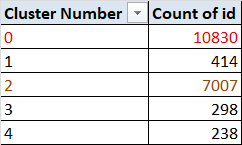

   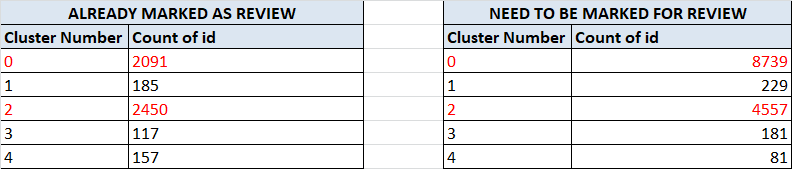

In [70]:
indices = np.argsort(clf.feature_importances_)[::-1]

In [71]:
#Using Recursive feature elmination
#The Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain.

from sklearn.feature_selection import RFE

import itertools

rfc = RandomForestClassifier()

# create the RFE model and select 20 attributes
rfe = RFE(rfc, n_features_to_select=20)
rfe = rfe.fit(x_train_res, y_train_res)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.izip_longest(rfe.get_support(), cols)]
selected_features = [v for i, v in feature_map if i==True]

In [72]:
# Selecting top 20 features for clustering
selected_features

['AGE_GROUP',
 'GENDER_GROUP',
 'INCOME_GROUP',
 'count',
 'proc_1',
 'proc_11',
 'proc_13',
 'proc_14',
 'proc_17',
 'proc_19',
 'proc_2',
 'proc_20',
 'proc_22',
 'proc_25',
 'proc_26',
 'proc_27',
 'proc_28',
 'proc_3',
 'proc_34',
 'proc_9']

    Preparing Data -
    Merging the anomalous data with review data to check if patients are comming together in specific clusters

In [74]:
df_subdata = df_anomalous.drop('prob_true', axis =1)

In [75]:
frames = [df_subdata, review_dataset]
medi_data = pd.concat(frames)

In [76]:
medi_data.head()

,AGE_GROUP,GENDER_GROUP,INCOME_GROUP,REVIEW_IND,count,id,proc_1,proc_10,proc_100,proc_101,...,proc_90,proc_91,proc_92,proc_93,proc_94,proc_95,proc_96,proc_97,proc_98,proc_99
2,1,0,5,0,3,7619,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,5,0,3,19302,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,4,1,3,0,2,27143,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,2,1,1,0,3,191852,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,1,0,3,0,4,322803,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
analysis_data = medi_data[selected_features]

In [78]:
analysis_data.head()

,AGE_GROUP,GENDER_GROUP,INCOME_GROUP,count,proc_1,proc_11,proc_13,proc_14,proc_17,proc_19,proc_2,proc_20,proc_22,proc_25,proc_26,proc_27,proc_28,proc_3,proc_34,proc_9
2,1,0,5,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0
8,4,0,5,3,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0
12,4,1,3,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
101,2,1,1,3,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
169,1,0,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [79]:
col_list = analysis_data.columns

In [80]:
col_list

Index([u'AGE_GROUP', u'GENDER_GROUP', u'INCOME_GROUP', u'count', u'proc_1',
       u'proc_11', u'proc_13', u'proc_14', u'proc_17', u'proc_19', u'proc_2',
       u'proc_20', u'proc_22', u'proc_25', u'proc_26', u'proc_27', u'proc_28',
       u'proc_3', u'proc_34', u'proc_9'],
      dtype='object')

    A. Standardizing the data

In [81]:
from sklearn.preprocessing import StandardScaler

In [82]:
sc=StandardScaler()

In [83]:
analysis_scaled=sc.fit_transform(analysis_data)

    B. Applying PCA

In [84]:
from sklearn.decomposition import PCA

In [85]:
var_ratio={}
for n in range(2,20):
    pc = PCA(n_components=n)
    analysis_pca=pc.fit(analysis_scaled)
    var_ratio[n]=sum(analysis_pca.explained_variance_ratio_)

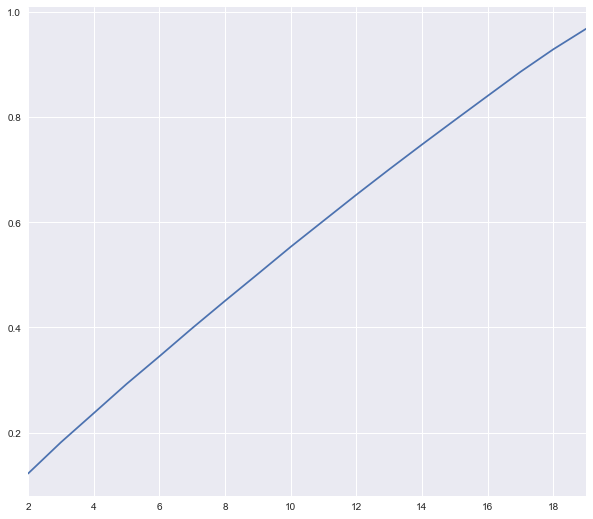

In [86]:
sns.set(rc={'figure.figsize':(10,9)})
pd.Series(var_ratio).plot()

In [87]:
var_ratio

{2: 0.12198882699180419,
 3: 0.18144482582904578,
 4: 0.23684074175199746,
 5: 0.29243228971704105,
 6: 0.34503284544264673,
 7: 0.39859515129899509,
 8: 0.45062388688422067,
 9: 0.50177501128141411,
 10: 0.55339081760559228,
 11: 0.60297362543909794,
 12: 0.65248385649994867,
 13: 0.70078059649746605,
 14: 0.74808441124281932,
 15: 0.7945437975746501,
 16: 0.84059353329444231,
 17: 0.88642096949273663,
 18: 0.9292693529614805,
 19: 0.9683548205113004}

In [88]:
# 16 component is defining 84% of variability
pc_final=PCA(n_components=16).fit(analysis_scaled)
reduced_cr=pc_final.fit_transform(analysis_scaled)

In [89]:
reduced_cr.shape

(18787L, 16L)

In [90]:
pd.DataFrame(pc_final.components_.T, columns=['PC_' + str(i) for i in range(16)], index=col_list)

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15
AGE_GROUP,0.465055,-0.091795,0.237413,-0.313491,0.203120,0.018979,0.211770,0.008828,-0.022960,-0.174176,-0.005132,-0.070673,0.053246,-0.172722,-0.069293,0.103386
GENDER_GROUP,-0.361407,0.341296,0.350635,-0.089041,-0.082037,-0.029111,0.157138,-0.097763,-0.155323,-0.044649,0.023136,0.002306,-0.087996,0.026854,-0.013146,0.018174
INCOME_GROUP,-0.489191,0.196266,-0.143357,0.301134,-0.025562,0.075932,0.332060,-0.113335,-0.069025,0.039316,0.127839,-0.011758,-0.085809,0.071609,-0.040471,-0.066013
count,-0.287345,-0.139660,-0.411087,-0.321242,0.377791,0.217415,0.101326,0.058608,-0.027018,0.130036,-0.154050,0.096756,0.280558,-0.055585,-0.115892,0.179691
proc_1,0.040558,0.055519,-0.006381,-0.031479,0.148028,0.333422,-0.016920,0.577953,-0.025402,-0.211865,0.210602,-0.107705,-0.354341,0.524692,0.055511,0.135026
proc_11,0.030338,-0.016431,0.104150,0.168529,-0.078933,-0.040989,0.249831,0.469651,-0.112930,0.376178,0.491330,-0.084119,0.361486,-0.295069,0.016662,0.052123
proc_13,-0.042827,0.084848,0.179376,0.122570,0.042975,0.260480,0.182975,0.229324,0.444841,0.159529,-0.546201,-0.009775,0.173964,0.085003,0.041433,-0.327988
proc_14,-0.042989,0.152835,-0.151934,0.140715,-0.163341,-0.025660,0.176515,0.050628,0.458373,-0.595886,0.046170,-0.106140,0.171683,-0.259652,0.256645,0.329658
proc_17,0.133053,0.012690,-0.228917,0.523339,0.295297,-0.243228,-0.231648,0.222623,-0.056177,0.042889,-0.190834,0.038547,0.167886,0.051902,0.016773,0.057369
proc_19,0.092801,0.252697,0.255545,-0.009929,0.400367,0.079053,0.215045,-0.148851,-0.134915,-0.160266,0.053537,-0.322254,0.343627,0.126352,-0.058697,-0.236082


In [91]:
pd.Series(pc_final.explained_variance_ratio_,index=['PC_' + str(i) for i in range(16)])

PC_0     0.063785
PC_1     0.062001
PC_2     0.057442
PC_3     0.056239
PC_4     0.054647
PC_5     0.053585
PC_6     0.052669
PC_7     0.051634
PC_8     0.051284
PC_9     0.050105
PC_10    0.049583
PC_11    0.049510
PC_12    0.048297
PC_13    0.047304
PC_14    0.046459
PC_15    0.046050
dtype: float64

    C. Clustering

#### Silhouette Coefficient

In [92]:
from sklearn import metrics
from sklearn.cluster import KMeans

In [125]:
# calculate SC for K=3 through K=15
k_range = range(3, 15)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(analysis_scaled)
    scores.append(metrics.silhouette_score(analysis_scaled, km.labels_))

In [126]:
scores

[0.10522821489446164,
 0.12842364571341527,
 0.21656637782788343,
 0.14030578920026074,
 0.15903030875281068,
 0.14911060962713901,
 0.15649049834719983,
 0.16251327883709377,
 0.19320061908571828,
 0.17892120286553026,
 0.18586687710013072,
 0.22024690876809028]

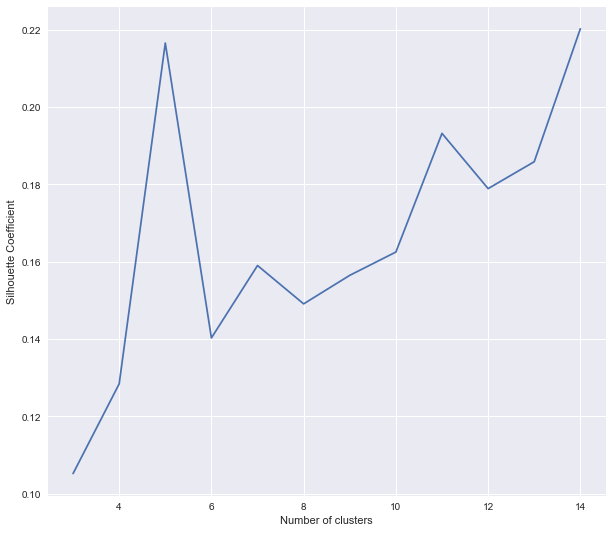

In [127]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

    Silhouette Coefficient shows 5 Cluster should be apt for the cause

#### Elbow Analysis

In [93]:
cluster_range = range( 1, 15 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( analysis_scaled )
    cluster_errors.append( clusters.inertia_ )

In [94]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df[0:10]

,cluster_errors,num_clusters
0,375740.000000,1
1,355568.069091,2
2,337045.758708,3
3,319771.759281,4
4,302226.497442,5
5,286226.505554,6
6,269408.939229,7
7,254251.397879,8
8,239451.324875,9
9,221930.677386,10


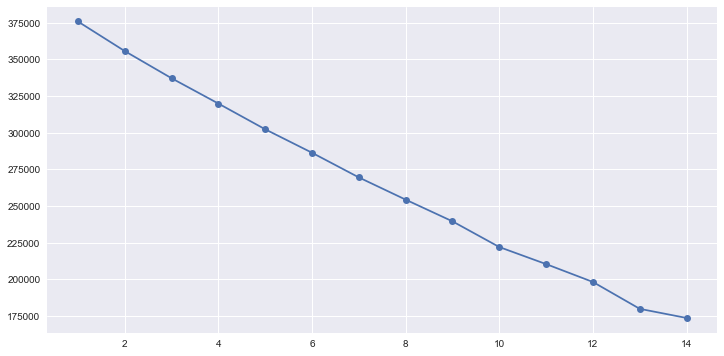

In [95]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

    The elbow diagram shows that the gain in explained variance reduces significantly from 4 to 5 to 6. So, optimal number of clusters could either 5 or 6. 

In [96]:
km_5=KMeans(init='k-means++', n_clusters=5,random_state=123)

In [97]:
km_5.fit(reduced_cr)
km_5.labels_

array([2, 2, 2, ..., 0, 0, 2])

In [98]:
pd.Series(km_5.labels_).value_counts()

0    10830
2     7007
1      414
3      298
4      238
dtype: int64

Text(0.5,0,u'PC_5')

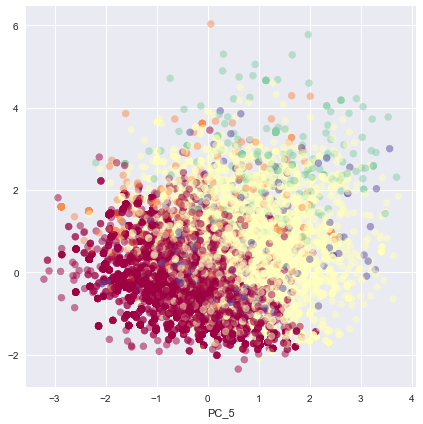

In [100]:
plt.figure(figsize=(7,7))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_5.labels_,cmap='Spectral',alpha=0.5)
plt.xlabel('PC_5')

In [101]:
km_5 = pd.DataFrame(km_5.labels_)

In [102]:
km_5.count()

0    18787
dtype: int64

In [106]:
medi_data = medi_data.reset_index()

In [107]:
cluster_df_5= pd.concat([medi_data, km_5], axis=1)

In [108]:
cluster_df_5.rename(columns={0: 'KMEANS_5'}, inplace=True)

In [109]:
cluster_df_5.to_csv('cluster_df_5.csv')

In [110]:
cluster_df_5.head()

,index,AGE_GROUP,GENDER_GROUP,INCOME_GROUP,REVIEW_IND,count,id,proc_1,proc_10,proc_100,...,proc_91,proc_92,proc_93,proc_94,proc_95,proc_96,proc_97,proc_98,proc_99,KMEANS_5
0,2,1,0,5,0,3,7619,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,8,4,0,5,0,3,19302,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,12,4,1,3,0,2,27143,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,101,2,1,1,0,3,191852,1,0,0,...,0,0,0,0,0,0,0,0,0,4
4,169,1,0,3,0,4,322803,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [111]:
cluster_to_audit = cluster_df_5[['id', 'REVIEW_IND', 'KMEANS_5']]

    We see the anomalous patients are getting grouped at Cluster 0 to the highest follwed by cluster 2

   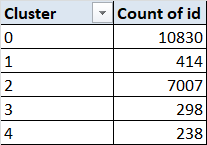